In [8]:
import opensim as osim
import pandas as pd
import numpy as np
import os

In [9]:
def extract_marker_locations(model_path):
    # Load the model
    model = osim.Model(model_path)
    
    # Initialize the system and get the default state
    state = model.initSystem()
    
    # Get the marker set from the model
    marker_set = model.getMarkerSet()
    
    # Create a dictionary to store marker locations
    marker_locations = {}
    
    # Loop through all markers and get their locations in ground frame
    for i in range(marker_set.getSize()):
        marker = marker_set.get(i)
        
        # Get the marker's location in ground frame
        location = marker.getLocationInGround(state)
        
        # Convert SimTK::Vec3 to a regular Python list or numpy array if needed
        location_array = np.array([location.get(0), location.get(1), location.get(2)])
        
        # Store in dictionary with marker name as key
        marker_locations[marker.getName()] = location_array
    
    return marker_locations


def data_frame(dict) -> pd.DataFrame:
    mrkrs_new = []
    for mrkr, location in dict.items():
        dic = {}
        dic['name'] = mrkr
        dic['r'] = location[0]*1000
        dic['a'] = location[1]*1000
        dic['s'] = location[2]*1000
        mrkrs_new.append(dic)

    # create the dataframe that contains all information
    osim_bone_markers_df = pd.DataFrame.from_dict(mrkrs_new)
    osim_bone_markers_df.set_index('name', inplace=True)
    return osim_bone_markers_df

In [10]:
# individual where data is located
ind = 'P01'

In [11]:
# load the generic model with bony markers from the template folder of the individual
generic_model_with_bone_landmarks = os.path.join(f'../../{ind}', 'templates','RajagopalModified_generic_copy_with_bone_markers.osim')

# load the generic model without the bony markers from the template folder of the individual
generic_model = os.path.join(f'../../{ind}', 'templates','RajagopalModified_generic_copy.osim')

# load landmarks in ground frame for each model
markers_with_bone_in_ground = extract_marker_locations(generic_model_with_bone_landmarks)
markers_skin_only_in_ground = extract_marker_locations(generic_model)

# create a list of bone landmarks
bone_landmark_names = [name for name in markers_with_bone_in_ground.keys() if name not in markers_skin_only_in_ground.keys()]

# dictioary of the landmarks of interest
bone_markers_in_ground = {name: markers_with_bone_in_ground[name] for name in bone_landmark_names}

In [12]:
bone_markers_in_ground_df = data_frame(bone_markers_in_ground)
bone_markers_in_ground_df.to_csv(os.path.join(f'../../{ind}', 'templates', 'bone_markers_in_ground.csv'), index=True)

Center of the best-fit sphere: [-9.02366306e+01 -2.72549893e+01  1.13536642e+05]
Radius of the best-fit sphere: 112827.57654100283


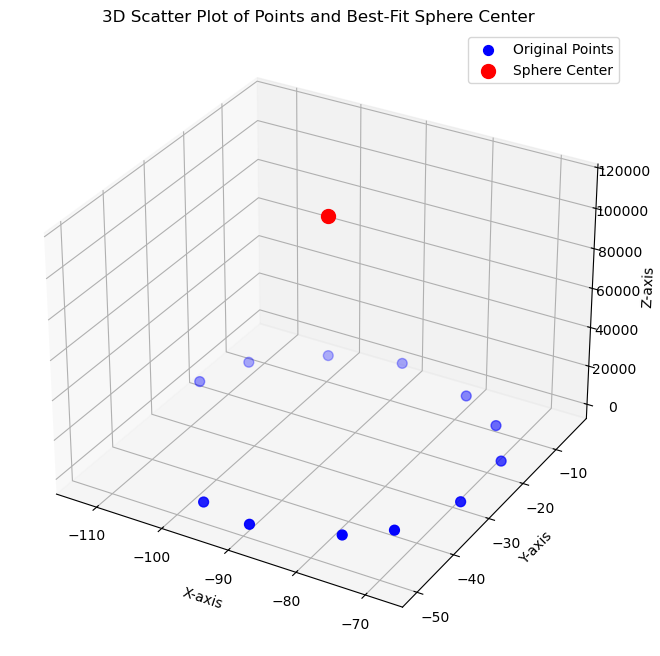

In [13]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Given points
points = np.array([
    [-96.5870715, -48.90232766, 709.0676815],
    [-88.78490233, -50.46276149, 709.0676815],
    [-77.34172089, -46.56167691, 709.0676815],
    [-72.14027478, -42.14044771, 709.0676815],
    [-67.9791179, -31.73755549, 709.0676815],
    [-67.9791179, -20.03430175, 709.0676815],
    [-72.6604194, -12.23213258, 709.0676815],
    [-79.68237164, -7.29075878, 709.0676815],
    [-91.38562539, -3.90981881, 709.0676815],
    [-101.268373, -7.29075878, 709.0676815],
    [-109.85075908, -14.57278333, 709.0676815],
    [-112.97162674, -22.6350248, 709.0676815]
])

# Define the residuals function for sphere fitting
# This function calculates the difference between the distance from each point to the
# proposed center and the proposed radius. The goal of the least_squares function
# is to minimize these residuals.
def sphere_residuals(params, points):
    # params contains [center_x, center_y, center_z, radius]
    center = params[:3]  # Extract the x, y, z coordinates of the center
    radius = params[3]   # Extract the radius

    # Calculate the Euclidean distance from each point to the proposed center
    distances = np.linalg.norm(points - center, axis=1)

    # Return the difference between these distances and the proposed radius.
    # These are the values that least_squares will try to minimize.
    return distances - radius

# Initial guess for the parameters (center and radius)
# A good initial guess helps the optimization algorithm converge faster and to a better solution.
# The mean of the points is a reasonable guess for the center.
initial_center = np.mean(points, axis=0)
# The average distance from the mean to the points is a reasonable guess for the radius.
initial_radius = np.mean(np.linalg.norm(points - initial_center, axis=1))
# Combine the initial center and radius into a single array for the optimizer.
initial_guess = np.append(initial_center, initial_radius)

# Perform least squares optimization to find the best-fit sphere parameters.
# 'sphere_residuals' is the function to minimize.
# 'initial_guess' is our starting point for the optimization.
# 'args=(points,)' passes the 'points' array as an additional argument to 'sphere_residuals'.
result = least_squares(sphere_residuals, initial_guess, args=(points,))

# Extract the fitted parameters from the optimization result.
# result.x contains the optimized parameters: [center_x, center_y, center_z, radius]
fitted_center = result.x[:3]
fitted_radius = result.x[3]

# Print the calculated center and radius
print(f"Center of the best-fit sphere: {fitted_center}")
print(f"Radius of the best-fit sphere: {fitted_radius}")

# --- Plotting the points and the sphere center ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', label='Original Points', s=50)

# Plot the calculated center
ax.scatter(fitted_center[0], fitted_center[1], fitted_center[2], color='red', marker='o', s=100, label='Sphere Center')

# Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Scatter Plot of Points and Best-Fit Sphere Center')
ax.legend()
ax.grid(True)
plt.show()


Center of the best-fit circle (3D): [ 84.29506968 -29.28326763 713.69953372]
Radius of the best-fit circle (2D): 22.29641046727011


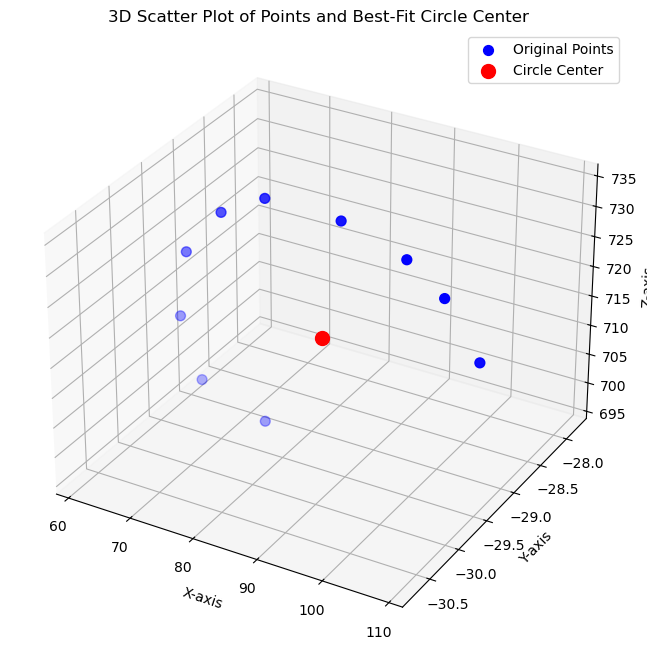

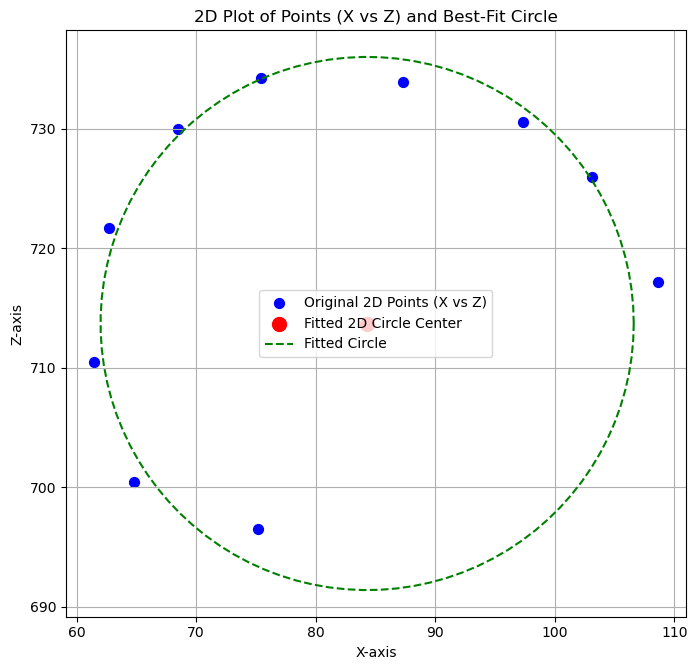

In [18]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Given points
points = np.array([
    [ 75.14383069, -29.28326763, 696.48551153],
    [ 64.80369204, -29.28326763, 700.43909396],
    [ 61.45835306, -29.28326763, 710.47511089],
    [ 62.67483996, -29.28326763, 721.72761471],
    [ 68.45315274, -29.28326763, 729.93890129],
    [ 75.44795241, -29.28326763, 734.19660544],
    [ 87.30869969, -29.28326763, 733.89248371],
    [ 97.34471662, -29.28326763, 730.54714474],
    [103.12302939, -29.28326763, 725.98531886],
    [108.59722044, -29.28326763, 717.16578884]
])

# Extract X and Y coordinates and the common Z coordinate
# Note: For these new points, the Z-coordinates are not all identical,
# but the Y-coordinates are. We will proceed with fitting a 2D circle
# to X and Z, assuming Y is the common "plane".
# If you intended a 3D sphere fit, please clarify.
xz_points = points[:, [0, 2]] # Use X and Z for 2D fitting
common_y = points[0, 1] # Assuming a common Y coordinate for the plane

# Define the residuals function for 2D circle fitting
def circle_residuals_2d(params, points_2d):
    center_2d = params[:2]
    radius_2d = params[2]
    distances_2d = np.linalg.norm(points_2d - center_2d, axis=1)
    return distances_2d - radius_2d

# Initial guess for the parameters (2D center and radius)
initial_center_2d = np.mean(xz_points, axis=0)
initial_radius_2d = np.mean(np.linalg.norm(xz_points - initial_center_2d, axis=1))
initial_guess_2d = np.append(initial_center_2d, initial_radius_2d)

# Perform least squares optimization to find the best-fit 2D circle parameters.
result_2d = least_squares(circle_residuals_2d, initial_guess_2d, args=(xz_points,))

# Extract the fitted 2D parameters
fitted_center_2d = result_2d.x[:2]
fitted_radius_2d = result_2d.x[2]

# Reconstruct the 3D center using the fitted X and Z, and the common Y
fitted_center_3d = np.array([fitted_center_2d[0], common_y, fitted_center_2d[1]])

# Print the calculated center and radius
print(f"Center of the best-fit circle (3D): {fitted_center_3d}")
print(f"Radius of the best-fit circle (2D): {fitted_radius_2d}")

# --- Plotting the points and the circle center ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', label='Original Points', s=50)

# Plot the calculated 3D center of the circle
ax.scatter(fitted_center_3d[0], fitted_center_3d[1], fitted_center_3d[2], color='red', marker='o', s=100, label='Circle Center')

# Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Scatter Plot of Points and Best-Fit Circle Center')
ax.legend()
ax.grid(True)
plt.show()

# Optional: Plot the 2D points and the fitted circle for clarity
plt.figure(figsize=(8, 8))
plt.scatter(xz_points[:, 0], xz_points[:, 1], color='blue', label='Original 2D Points (X vs Z)', s=50)
plt.scatter(fitted_center_2d[0], fitted_center_2d[1], color='red', marker='o', s=100, label='Fitted 2D Circle Center')

# Draw the fitted circle
theta = np.linspace(0, 2*np.pi, 100)
x_circle_2d = fitted_center_2d[0] + fitted_radius_2d * np.cos(theta)
z_circle_2d = fitted_center_2d[1] + fitted_radius_2d * np.sin(theta)
plt.plot(x_circle_2d, z_circle_2d, color='green', linestyle='--', label='Fitted Circle')

plt.xlabel('X-axis')
plt.ylabel('Z-axis') # Changed to Z-axis for clarity
plt.title('2D Plot of Points (X vs Z) and Best-Fit Circle')
plt.gca().set_aspect('equal', adjustable='box') # Ensure equal aspect ratio
plt.legend()
plt.grid(True)
plt.show()
